# QA/QC on CSO data using IQRs and z-scores

## IQR:

$$IQR = Q3-Q1$$

A datapoint is an outlier if:
$$value < Q1 - 1.5 * IQR$$
$$value > Q3 - 1.5 * IQR$$

## z-scores:
$$
z = \frac{value - \mu}{\sigma}
$$

A datapoint is an outlier if:

$$z < -3$$
$$z > 3$$

* threshold could be some number besides 3

In [1]:
import numpy as np 
import pandas as pd
from datetime import date, timedelta
import glob
import geopandas as gpd
import requests
from rasterstats import zonal_stats, point_query

In [2]:
# define directory for tif files
clim_dir = '/nfs/attic/dfh/data/snodas/snodas_tif/clim/'
hs_dir = '/nfs/attic/dfh/data/snodas/snodas_tif/daily_Hs/'

## Get CSO data

In [3]:
domain = 'WY'

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

Bbox = domains[domain]['Bbox']
stn_proj = domains[domain]['stn_proj']
mod_proj = domains[domain]['mod_proj']
stn_proj

'epsg:4326'

In [31]:
st = '2016-10-01'
ed = '2020-09-30'
#Restrict points to the coterminous US
region = {
    'latmax' : 50,
    'latmin' : 25,
    'lonmax': -65,
    'lonmin': -125,}

def get_cso(st, ed, Bbox):

    #Issue CSO API observations request and load the results into a GeoDataFrame
    params = {
      "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
      "start_date": st,
      "end_date": ed,
      "format": "geojson",
      "limit": 5000,
    }

    csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
    csodatajson = csodata_resp.json()
    #turn into geodataframe
    gdf = gpd.GeoDataFrame.from_features(csodatajson, crs='epsg:4326')
    
    mask = (gdf['timestamp'] >= st) & (gdf['timestamp'] <= ed)
    gdf = gdf.loc[mask]
    ingdf=gdf.reset_index(drop=True)
    print('Total number of CSO in domain = ',len(ingdf))
    
    #need to format data for Hs_to_SWE conversion
    ingdf['dt'] = pd.to_datetime(ingdf['timestamp'], format='%Y-%m-%dT%H:%M:%S').dt.date
    #ingdf['dt'] = pd.to_datetime(ingdf['dt']).dt.date
    ingdf['Y'] = pd.DatetimeIndex(ingdf['dt']).year
    ingdf['M'] = pd.DatetimeIndex(ingdf['dt']).month
    ingdf['D'] = pd.DatetimeIndex(ingdf['dt']).day
    ingdf["LON"] = ingdf.geometry.x
    ingdf["LAT"] = ingdf.geometry.y
    ingdf=ingdf.drop(columns=['dt'])
    
    #convert snow depth to mm to input into density function
    ingdf['H'] = ingdf.depth*10

    return ingdf
csodf = get_cso(st, ed, region)

Total number of CSO in domain =  2076


In [37]:
# temporary test only looking at january data 

csodf = csodf.loc[(csodf.M==1)]
csodf.reset_index(inplace= True,drop=True)
csodf

,geometry,id,author,depth,source,timestamp,elevation,Y,M,D,LON,LAT,H
0,POINT (-109.94426 45.06893),CsEv4wf9,Alex Marienthal,175.00,SnowPilot,2020-01-31T23:00:00.000Z,2788.390381,2020,1,31,-109.944262,45.068929,1750.0
1,POINT (-118.23704 44.95062),zChBnJcl,Bart Wills,113.00,MountainHub,2020-01-31T22:58:15.824Z,2352.066895,2020,1,31,-118.237041,44.950622,1130.0
2,POINT (-110.08001 43.68014),1AzdBZDU,JD,105.00,MountainHub,2020-01-31T22:51:31.086Z,2688.787842,2020,1,31,-110.080012,43.680140,1050.0
3,POINT (-121.67724 44.05789),Sz6gJKZB,Aaron Hartz,315.00,MountainHub,2020-01-31T22:48:17.236Z,2145.914795,2020,1,31,-121.677245,44.057887,3150.0
4,POINT (-105.75817 40.28380),7FkpLoHX,Ryan Lewthwaite,100.00,SnowPilot,2020-01-31T22:40:00.000Z,3405.821533,2020,1,31,-105.758171,40.283802,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,POINT (-120.25920 48.59015),JRqk4nbc,David Hill,27.00,MountainHub,2020-01-01T19:33:16.333Z,1030.113403,2020,1,1,-120.259198,48.590153,270.0
236,POINT (-120.25241 48.58254),4moz/QBW,David Hill,25.00,MountainHub,2020-01-01T19:16:49.415Z,915.497803,2020,1,1,-120.252412,48.582536,250.0
237,POINT (-120.23395 48.57739),IWrAvuUx,David Hill,25.00,MountainHub,2020-01-01T18:43:46.795Z,917.771790,2020,1,1,-120.233953,48.577390,250.0
238,POINT (-121.88252 44.40181),9MCeaWUD,David Hill,35.56,MountainHub,2020-01-01T17:12:25.942Z,1528.574219,2020,1,1,-121.882517,44.401809,355.6


## IQR flags

In [38]:
snodas_hs = []
iqr_flag = []
q1s = []
q3s = []
IQRs = []
for i in range(len(csodf)):
    print(i)
    # get cso snow depth
    csohs = csodf.H[i]
    # get date
    date = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')
    
    # define path names
    snodas_Fname = hs_dir+'us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.tif'
    q1_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036q1.tif'
    q3_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036q3.tif'

    snodas_hs.append(point_query([csodf.geometry[i]], snodas_Fname)[0])
    q1 = point_query([csodf.geometry[i]], q1_Fname)[0]
    q1s.append(q1)
    q3 = point_query([csodf.geometry[i]], q3_Fname)[0]
    q3s.append(q3)
    IQR = q3-q1
    IQRs.append(q3-q1)
    #print(csohs,q1-1.5*IQR,q3+1.5*IQR,(csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))
    iqr_flag.append((csohs > (q1-1.5*IQR)) & (csohs < (q3+1.5*IQR)))
        
csodf['snodas'] = snodas_hs
csodf['iqr_flag'] = iqr_flag
csodf['q1'] = q1s
csodf['q3'] = q3s
csodf['IQR'] = IQRs

0
1
2
3
4


/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [39]:
csodf

,geometry,id,author,depth,source,timestamp,elevation,Y,M,D,LON,LAT,H,snodas,iqr_flag,q1,q3,IQR
0,POINT (-109.94426 45.06893),CsEv4wf9,Alex Marienthal,175.00,SnowPilot,2020-01-31T23:00:00.000Z,2788.390381,2020,1,31,-109.944262,45.068929,1750.0,1427.022167,True,1448.742206,2165.675080,716.932873
1,POINT (-118.23704 44.95062),zChBnJcl,Bart Wills,113.00,MountainHub,2020-01-31T22:58:15.824Z,2352.066895,2020,1,31,-118.237041,44.950622,1130.0,1501.141006,True,801.370184,1355.708182,554.337998
2,POINT (-110.08001 43.68014),1AzdBZDU,JD,105.00,MountainHub,2020-01-31T22:51:31.086Z,2688.787842,2020,1,31,-110.080012,43.680140,1050.0,908.837291,True,996.390691,1531.575480,535.184789
3,POINT (-121.67724 44.05789),Sz6gJKZB,Aaron Hartz,315.00,MountainHub,2020-01-31T22:48:17.236Z,2145.914795,2020,1,31,-121.677245,44.057887,3150.0,2712.349187,True,893.092091,1874.724033,981.631942
4,POINT (-105.75817 40.28380),7FkpLoHX,Ryan Lewthwaite,100.00,SnowPilot,2020-01-31T22:40:00.000Z,3405.821533,2020,1,31,-105.758171,40.283802,1000.0,979.066378,True,673.821076,982.716680,308.895604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,POINT (-120.25920 48.59015),JRqk4nbc,David Hill,27.00,MountainHub,2020-01-01T19:33:16.333Z,1030.113403,2020,1,1,-120.259198,48.590153,270.0,393.546982,True,421.178714,751.611040,330.432326
236,POINT (-120.25241 48.58254),4moz/QBW,David Hill,25.00,MountainHub,2020-01-01T19:16:49.415Z,915.497803,2020,1,1,-120.252412,48.582536,250.0,372.542109,True,404.530300,703.201106,298.670807
237,POINT (-120.23395 48.57739),IWrAvuUx,David Hill,25.00,MountainHub,2020-01-01T18:43:46.795Z,917.771790,2020,1,1,-120.233953,48.577390,250.0,333.330233,True,386.233675,710.680775,324.447100
238,POINT (-121.88252 44.40181),9MCeaWUD,David Hill,35.56,MountainHub,2020-01-01T17:12:25.942Z,1528.574219,2020,1,1,-121.882517,44.401809,355.6,282.376653,True,385.664025,1505.180889,1119.516864


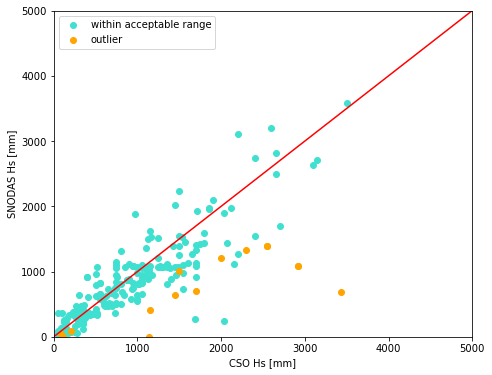

In [40]:
import matplotlib.pyplot as plt
# create data
x = csodf.H[csodf.iqr_flag==True]
y = csodf.snodas[csodf.iqr_flag==True]
x_flag = csodf.H[csodf.iqr_flag==False]
y_flag = csodf.snodas[csodf.iqr_flag==False]

plt.figure(1, figsize=[7.5,6])
plt.plot(np.arange(0,5000), np.arange(0,5000),'r')
plt.scatter(x, y,c='turquoise',label='within acceptable range')
plt.scatter(x_flag, y_flag,c='orange',label='outlier')
plt.ylabel('SNODAS Hs [mm]')
plt.ylim([0,5000])
plt.xlabel('CSO Hs [mm]')
plt.xlim([0,5000])
plt.legend()

## z-score flags

In [58]:
z_flag = []
snodas_hs =[]
for i in range(len(csodf)):
    #print(i)
    # get cso snow depth
    csohs = csodf.H[i]
    # get date
    date = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')
    
    # define path names
    snodas_Fname = hs_dir+'us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.tif'    
    std_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036std.tif'
    mean_Fname = clim_dir+date.strftime("%m")+date.strftime("%d")+'1036mean.tif'

    snodas_hs.append(point_query([csodf.geometry[i]], snodas_Fname)[0])
    std = point_query([csodf.geometry[i]], std_Fname)[0]
    mean = point_query([csodf.geometry[i]], mean_Fname)[0]
    try: 
        z_score = (csohs - mean)/std
        #print(i,std,mean,z_score)
        z_flag.append((z_score > -3) & (z_score < 3))
    except:
        z_flag.append(False)
        
csodf['snodas'] = snodas_hs
csodf['z_flag'] = z_flag

/nfs/attic/dfh/miniconda/envs/snowmodelcal/lib/python3.6/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


0 448.8012099223108 1822.1167480096756 -0.16068750799972054
1 434.4049350862822 955.6628916943386 0.40132395887959776
2 343.50649190081583 1253.821806581982 -0.5933564907438009
3 792.8524508011275 1237.0198894537773 2.4127819856182278
4 244.3361103841417 852.94276002883 0.6018645370918312
5 726.5844610447682 1578.1120525439737 0.16775468509299182
6 290.8369864190774 1197.0035510777484 -1.5369556554050008
7 297.24129968010936 1366.2619687949993 -1.9050581780001958
8 486.57279870242394 1793.0685483904597 0.5074912783206312
9 280.3384056908689 1373.4332019666613 0.45147862534719846
10 284.42311294839396 1463.2754234146544 -0.7498526445470389
11 594.2263164119981 1519.803000000052 1.144676668154063
12 302.15994229158264 1194.5646720000036 -0.809388134460259
13 302.15994229158264 1194.5646720000036 -0.809388134460259
14 302.03155663579196 822.4081366639643 1.7468103969421913
15 249.12331247576122 902.7754680319937 2.397304876981812
16 302.15994229158264 1194.5646720000036 -0.809388134460259

In [59]:
csodf

,geometry,id,author,depth,source,timestamp,elevation,Y,M,D,LON,LAT,H,iqr_flag,q1,q3,IQR,snodas,z_flag
0,POINT (-109.94426 45.06893),CsEv4wf9,Alex Marienthal,175.00,SnowPilot,2020-01-31T23:00:00.000Z,2788.390381,2020,1,31,-109.944262,45.068929,1750.0,True,1448.742206,2165.675080,716.932873,1427.022167,True
1,POINT (-118.23704 44.95062),zChBnJcl,Bart Wills,113.00,MountainHub,2020-01-31T22:58:15.824Z,2352.066895,2020,1,31,-118.237041,44.950622,1130.0,True,801.370184,1355.708182,554.337998,1501.141006,True
2,POINT (-110.08001 43.68014),1AzdBZDU,JD,105.00,MountainHub,2020-01-31T22:51:31.086Z,2688.787842,2020,1,31,-110.080012,43.680140,1050.0,True,996.390691,1531.575480,535.184789,908.837291,True
3,POINT (-121.67724 44.05789),Sz6gJKZB,Aaron Hartz,315.00,MountainHub,2020-01-31T22:48:17.236Z,2145.914795,2020,1,31,-121.677245,44.057887,3150.0,True,893.092091,1874.724033,981.631942,2712.349187,True
4,POINT (-105.75817 40.28380),7FkpLoHX,Ryan Lewthwaite,100.00,SnowPilot,2020-01-31T22:40:00.000Z,3405.821533,2020,1,31,-105.758171,40.283802,1000.0,True,673.821076,982.716680,308.895604,979.066378,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,POINT (-120.25920 48.59015),JRqk4nbc,David Hill,27.00,MountainHub,2020-01-01T19:33:16.333Z,1030.113403,2020,1,1,-120.259198,48.590153,270.0,True,421.178714,751.611040,330.432326,393.546982,True
236,POINT (-120.25241 48.58254),4moz/QBW,David Hill,25.00,MountainHub,2020-01-01T19:16:49.415Z,915.497803,2020,1,1,-120.252412,48.582536,250.0,True,404.530300,703.201106,298.670807,372.542109,True
237,POINT (-120.23395 48.57739),IWrAvuUx,David Hill,25.00,MountainHub,2020-01-01T18:43:46.795Z,917.771790,2020,1,1,-120.233953,48.577390,250.0,True,386.233675,710.680775,324.447100,333.330233,True
238,POINT (-121.88252 44.40181),9MCeaWUD,David Hill,35.56,MountainHub,2020-01-01T17:12:25.942Z,1528.574219,2020,1,1,-121.882517,44.401809,355.6,True,385.664025,1505.180889,1119.516864,282.376653,True


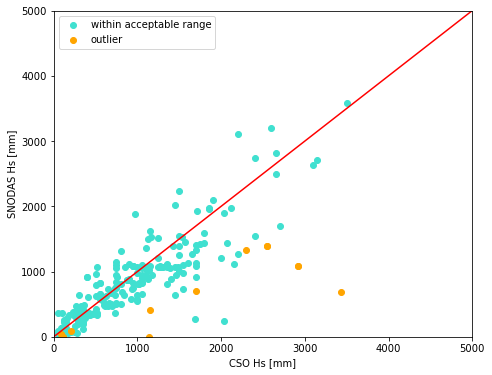

In [60]:
import matplotlib.pyplot as plt
# create data
x = csodf.H[csodf.z_flag==True]
y = csodf.snodas[csodf.z_flag==True]
x_flag = csodf.H[csodf.z_flag==False]
y_flag = csodf.snodas[csodf.z_flag==False]

plt.figure(1, figsize=[7.5,6])
plt.plot(np.arange(0,5000), np.arange(0,5000),'r')
plt.scatter(x, y,c='turquoise',label='within acceptable range')
plt.scatter(x_flag, y_flag,c='orange',label='outlier')
plt.ylabel('SNODAS Hs [mm]')
plt.ylim([0,5000])
plt.xlabel('CSO Hs [mm]')
plt.xlim([0,5000])
plt.legend()